Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [16]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.layers import \
    (Rescaling, Conv2D, AveragePooling2D, Activation,
     MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout,
     RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from tensorflow.keras.models import Sequential
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(os.path.join(os.path.curdir, "Skin cancer ISIC The International Skin Imaging Collaboration", "train"))
data_dir_test = pathlib.Path(os.path.join(os.path.curdir, "Skin cancer ISIC The International Skin Imaging Collaboration", "test"))

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
random_seed = 123
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=random_seed,
    validation_split=0.2,
    subset="training",
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Metal device set to: Apple M1 Max


2022-04-20 19:38:33.459795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 19:38:33.459929: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
    
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2022-04-20 19:38:38.555536: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


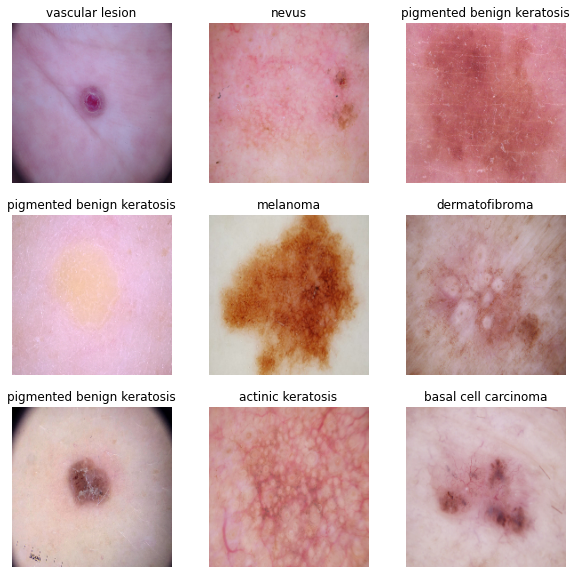

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
### Your code goes here
num_classes = len(class_names)

model = Sequential(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [11]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/Users/jagadeesh/tensorflow-test/env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-04-20 20:07:46.957423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/56 [============================>.] - ETA: 0s - loss: 2.1719 - accuracy: 0.2602

2022-04-20 20:07:55.365140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 10s 63ms/step - loss: 2.1650 - accuracy: 0.2640 - val_loss: 1.8314 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.7306 - accuracy: 0.3566 - val_loss: 1.8529 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5230 - accuracy: 0.4782 - val_loss: 1.4831 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4358 - accuracy: 0.4961 - val_loss: 1.5743 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3567 - accuracy: 0.5173 - val_loss: 1.3791 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3039 - accuracy: 0.5307 - val_loss: 1.4122 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2358 - accuracy: 0.5441 - val_loss: 1.4303 - val_accuracy: 0.5213
Epoch 8/20
56/56 [=====

### Visualizing training results

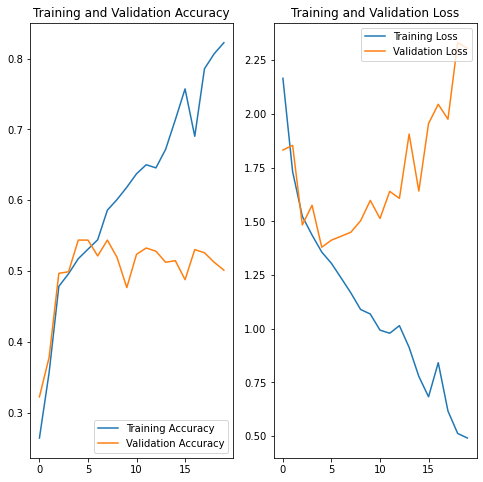

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

#### Todo, after you have analysed the model fit history for presence of underfit or overfit, 

 - The initial model is overfitted


In [35]:
# choose an appropriate data augumentation strategy.
with tf.device('/CPU:0'):
    data_augmentation = tf.keras.Sequential([
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        RandomFlip("horizontal_and_vertical", seed=random_seed),
        RandomRotation(0.2, seed=random_seed),
        RandomZoom(0.3, 0.2, seed=random_seed),
    ])

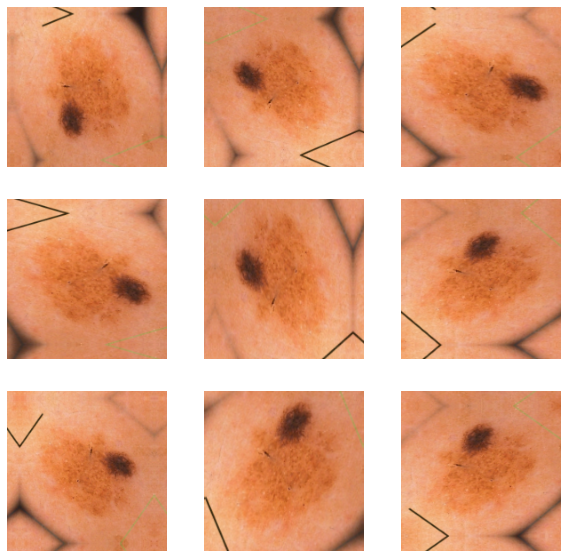

In [36]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
image, label = next(iter(train_ds))
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
plt.show()

### Todo:
### Create the model, compile and train the model


In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_1 = Sequential()
model_1.add(data_augmentation)
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.20))

model_1.add(Conv2D(64, (3, 3), padding='same',  activation='relu'))
model_1.add(Conv2D(64, (5, 5), padding='same',  activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.20))

model_1.add(Flatten())
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dense(num_classes))

### Compiling the model

In [39]:
## Your code goes here
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 32)       

### Training the model

In [41]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-04-20 20:49:42.269029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 40.5428 - accuracy: 0.2751

2022-04-20 20:49:53.329346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 12s 190ms/step - loss: 40.5428 - accuracy: 0.2751 - val_loss: 44.3398 - val_accuracy: 0.0872
Epoch 2/20
56/56 [==============================] - 11s 187ms/step - loss: 1.9695 - accuracy: 0.3253 - val_loss: 51.2810 - val_accuracy: 0.1678
Epoch 3/20
56/56 [==============================] - 10s 187ms/step - loss: 1.6865 - accuracy: 0.3772 - val_loss: 69.7875 - val_accuracy: 0.2103
Epoch 4/20
56/56 [==============================] - 10s 184ms/step - loss: 1.5908 - accuracy: 0.4213 - val_loss: 84.7122 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 10s 184ms/step - loss: 1.4813 - accuracy: 0.4682 - val_loss: 105.5286 - val_accuracy: 0.2036
Epoch 6/20
56/56 [==============================] - 10s 187ms/step - loss: 1.4292 - accuracy: 0.4816 - val_loss: 48.3671 - val_accuracy: 0.1723
Epoch 7/20
56/56 [==============================] - 11s 187ms/step - loss: 1.4539 - accuracy: 0.4922 - val_loss: 53.5258 - val_accuracy: 0.1924
E

### Visualizing the results

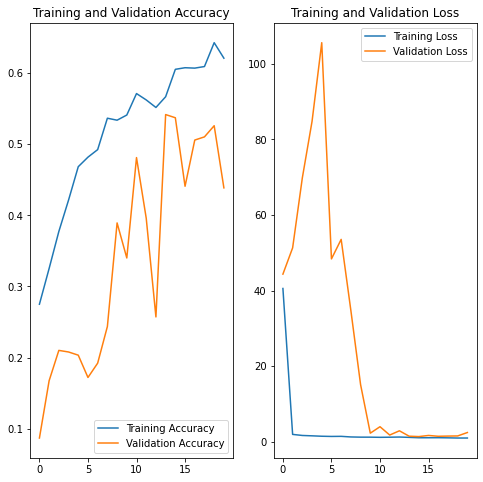

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
 - model is underfitted

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [43]:
## Your code goes here.
labels = []
for tr, label in train_ds.enumerate():
    labels.extend(label[1].numpy().tolist())

In [48]:
for i in range(9):
    print(f"Class: {class_names[i]} count is - {labels.count(i)}")

Class: actinic keratosis count is - 92
Class: basal cell carcinoma count is - 309
Class: dermatofibroma count is - 77
Class: melanoma count is - 352
Class: nevus count is - 277
Class: pigmented benign keratosis count is - 370
Class: seborrheic keratosis count is - 58
Class: squamous cell carcinoma count is - 142
Class: vascular lesion count is - 115


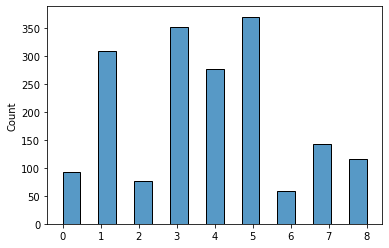

In [45]:
sns.histplot(labels)
plt.show()

##### Data is highly imbalanced and it is observed from above hist plot

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
        -  seborrheic keratosis count is 58
#### - Which classes dominate the data in terms proportionate number of samples?
        -  pigmented benign keratosis is dominated with count of 370


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [50]:
path_to_training_dataset=data_dir_train.absolute().as_posix() + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x32922F280>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 359.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2CF22DD00>: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 369.82 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CF2B2DF0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 358.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x31DF4C370>: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 82.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x3290B83A0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 78.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CF26DC10>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 340.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x31DF4C130>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 152.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3290CB820>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 345.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/jagadeesh/Upgrad/Git/DeepLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31580DCD0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 351.00 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [55]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [56]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [57]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [58]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df.shape

(2239, 2)

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

/var/folders/8t/bql9n_hs2bsd09p21yx8tl5r0000gn/T/ipykernel_12519/390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [60]:
new_df['Label'].value_counts()

train                         2239
melanoma                       500
pigmented benign keratosis     500
nevus                          500
basal cell carcinoma           500
actinic keratosis              500
squamous cell carcinoma        500
vascular lesion                500
seborrheic keratosis           500
dermatofibroma                 500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [63]:
data_dir_train = pathlib.Path(os.path.join(os.path.curdir, "Skin cancer ISIC The International Skin Imaging Collaboration", "train"))
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=random_seed,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [64]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=random_seed,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [66]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model_2 = Sequential()
model_2.add(Rescaling(1/255., input_shape=(img_height, img_width, 3)))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Conv2D(32, (3, 3), padding='same',  activation='relu'))
model_2.add(Conv2D(32, (5, 5), padding='same',  activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Flatten())
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(0.20))
model_2.add(Dense(num_classes))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [69]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2022-04-20 21:33:58.461006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - ETA: 0s - loss: 8.5411 - accuracy: 0.2511

2022-04-20 21:34:21.740138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 26s 105ms/step - loss: 8.5411 - accuracy: 0.2511 - val_loss: 35.2197 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 16s 93ms/step - loss: 1.6546 - accuracy: 0.3507 - val_loss: 32.1568 - val_accuracy: 0.1299
Epoch 3/30
169/169 [==============================] - 16s 92ms/step - loss: 1.4952 - accuracy: 0.3976 - val_loss: 7.7659 - val_accuracy: 0.2220
Epoch 4/30
169/169 [==============================] - 16s 92ms/step - loss: 1.3712 - accuracy: 0.4462 - val_loss: 1.4133 - val_accuracy: 0.4454
Epoch 5/30
169/169 [==============================] - 16s 92ms/step - loss: 1.2696 - accuracy: 0.4881 - val_loss: 1.6676 - val_accuracy: 0.4395
Epoch 6/30
169/169 [==============================] - 16s 94ms/step - loss: 1.1366 - accuracy: 0.5419 - val_loss: 1.5129 - val_accuracy: 0.4766
Epoch 7/30
169/169 [==============================] - 16s 92ms/step - loss: 1.0509 - accuracy: 0.5781 - val_loss: 1.4019 - val_accuracy: 0.4840


#### **Todo:**  Visualize the model results

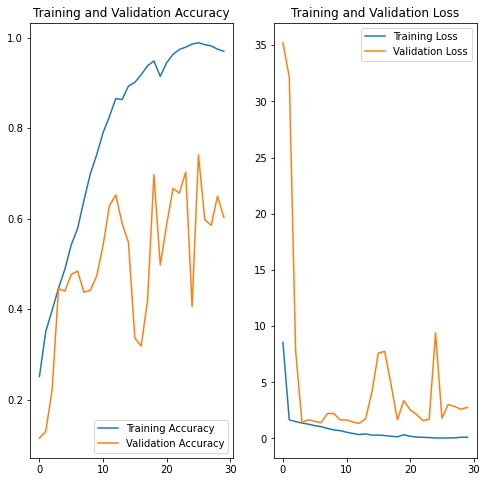

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

